In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import random
import math

import numpy as np
np.random.seed(1)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
#%matplotlib notebook

from numpy.linalg import inv
from numpy import linalg as LA
from scipy import linalg
import random

from matplotlib import animation, rc
from IPython.display import HTML

In [17]:
df = pd.read_csv('training_data.csv')

In [21]:
FM = df.values
dim = np.shape(FM)

In [25]:
#ignore rotations and moments

F = FM[:,0:int(dim[1]/2)]
F = F[:,0::2]
D = FM[:,int(dim[1]/2):] 
D = D[:,0::2] 

In [47]:
#Training data

n_timesteps, n_nodes = np.shape(D)
d = 10 #number of steps in "model memory"
t = d

X_train = np.zeros([n_timesteps-d, 2*d*n_nodes+n_nodes])
Y_train = np.zeros([n_timesteps-d, n_nodes])


for i in range(n_timesteps-d):
    
    bulk = 0
    for j in range(n_nodes):
        X_train[i, bulk:bulk + d+1] = F[t-d:t+1,j]    
        bulk += d+1
    
    for j in range(n_nodes):
        X_train[i, bulk:bulk + d] = D[t-d:t,j]
        bulk += d
    
    #for j in range(n_nodes):
     #   X_train[i, bulk: bulk + d] = Dt[t-d:t,j]/rt_max
      #  bulk += d

    Y_train[i, 0:n_nodes] = D[i, :]
    #Y_train[i, n_nodes:] = Dt[i, :]/rt_max
    t += 1


In [48]:
#Neural network

train_portion = 0.8
input_dim = len(X_train[0,:])
output_dim = len(Y_train[0,:])

x_train = X_train[0:int(n_timesteps*train_portion),:]
x_test = X_train[int(n_timesteps*(train_portion)):,:]
y_train = Y_train[0:int(n_timesteps*train_portion),:]
y_test = Y_train[int(n_timesteps*(train_portion)):,:]

def baseline_model():
    model = Sequential()
    height = 150
    model.add(Dense(height, input_dim=input_dim, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(height, input_dim=height, activation='tanh', kernel_initializer='normal'))
    model.add(Dense(output_dim, input_dim=height, activation='linear', kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer="adam")
    return model



# Training the model
model = baseline_model()
model.fit(x_train, y_train, epochs=100, verbose = 1)

Epoch 1/100
2400/2400 [==============================] - 1s 223us/step - loss: 1.1881e-04
Epoch 2/100
2400/2400 [==============================] - 0s 173us/step - loss: 5.1812e-06
Epoch 3/100
2400/2400 [==============================] - 0s 110us/step - loss: 3.1820e-06
Epoch 4/100
2400/2400 [==============================] - 0s 107us/step - loss: 2.0763e-06
Epoch 5/100
2400/2400 [==============================] - 0s 110us/step - loss: 1.3587e-06
Epoch 6/100
2400/2400 [==============================] - 0s 152us/step - loss: 1.1679e-06
Epoch 7/100
2400/2400 [==============================] - 0s 128us/step - loss: 1.1986e-06
Epoch 8/100
2400/2400 [==============================] - 0s 129us/step - loss: 1.4756e-06
Epoch 9/100
2400/2400 [==============================] - 0s 174us/step - loss: 1.4494e-06
Epoch 10/100
2400/2400 [==============================] - 0s 103us/step - loss: 7.1978e-07
Epoch 11/100
2400/2400 [==============================] - 0s 122us/step - loss: 6.7115e-07
Epoch 12

2400/2400 [==============================] - 0s 114us/step - loss: 1.2257e-06
Epoch 92/100
2400/2400 [==============================] - 0s 104us/step - loss: 6.1771e-07
Epoch 93/100
2400/2400 [==============================] - 0s 100us/step - loss: 5.3823e-07
Epoch 94/100
2400/2400 [==============================] - 0s 109us/step - loss: 2.2698e-07
Epoch 95/100
2400/2400 [==============================] - 0s 104us/step - loss: 5.2636e-07
Epoch 96/100
2400/2400 [==============================] - 0s 116us/step - loss: 5.0636e-07
Epoch 97/100
2400/2400 [==============================] - 0s 98us/step - loss: 8.6764e-07
Epoch 98/100
2400/2400 [==============================] - 0s 112us/step - loss: 2.9382e-07
Epoch 99/100
2400/2400 [==============================] - 0s 106us/step - loss: 1.1459e-06
Epoch 100/100
2400/2400 [==============================] - 0s 107us/step - loss: 1.0232e-06


In [49]:
predictions = model.predict(x_test)

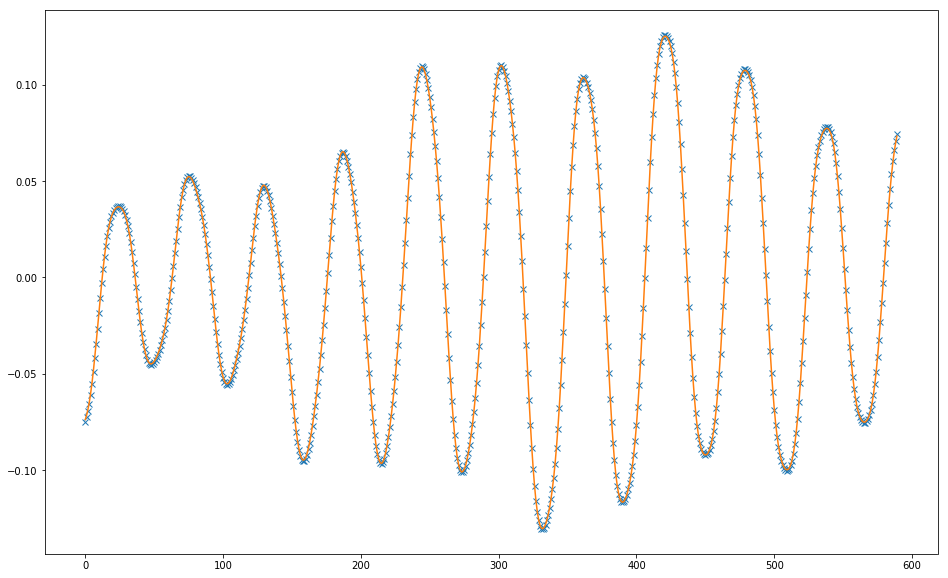

In [50]:
plt.figure(figsize=(16,10))
plt.plot(predictions[:,n_nodes-1], 'x')
plt.plot(y_test[:, n_nodes-1])
plt.show()

In [51]:
#Errorfunction
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [52]:
#Error
print(rmse(predictions[:,n_nodes-1], y_test[:,n_nodes-1]))

0.000532277902906


In [81]:
#independent prediction

input_i = np.copy(x_test[0,:])

dz = np.copy(input_i[(d+1)*n_nodes:])

dz = np.reshape(dz, (d, n_nodes))


#dzt = np.copy(input_i[d+1+n_nodes*d:])
#dzt = np.reshape(dzt, (n_nodes, d))

preds = np.zeros([len(x_test[:,0])-1, n_nodes])
force = np.copy(x_test[:, 0:(d+1)*n_nodes])

for i in range(len(x_test[:,0])-1):
    
    
    pred = model.predict(np.reshape(input_i,(1,len(input_i))))
    preds[i, :] = pred
    
    input_i[0:(d+1)*n_nodes] = force[i+1,:]
    
    dz = np.delete(dz, 0, 0)
    dz = np.concatenate((dz, np.reshape(pred[0,:], (1,n_nodes))), axis=0)
    dz[0,:] = np.zeros(n_nodes)
    #dzt = np.delete(dzt, 0, 1)
    #dzt = np.concatenate((dzt, np.reshape(pred[0,n_nodes:], (1, n_nodes)).T), axis=1)
    #dzt[0,:] = np.zeros(n_nodes)
    input_i[(d+1)*n_nodes:] = np.reshape(dz, (1, n_nodes*d))[0]
    #input_i[d+1+n_nodes*d:] = np.reshape(dzt, (1, n_nodes*d))[0]
    

    

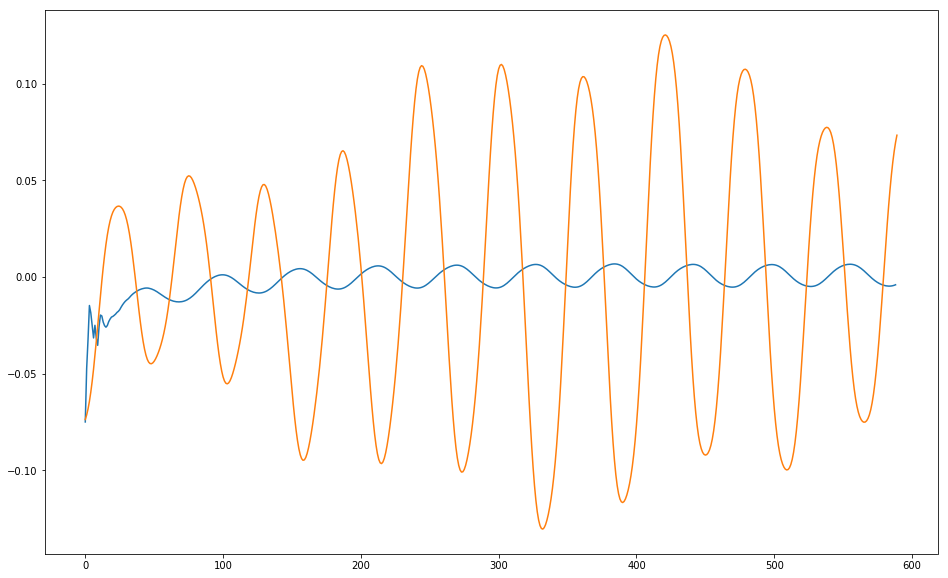

In [82]:
plt.figure(figsize=(16,10))
plt.plot(preds[:,n_nodes-1], '-')
plt.plot(y_test[:, n_nodes-1])
plt.show()